In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torch.utils.data import Dataset
from sklearn.datasets import make_moons
from torch import Tensor

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cpu


In [3]:
# Visualization functions
def plot_density(model, loader=[], batch_size=100, mesh_size=5., device="cpu"):
    """Plot the density of a normalizing flow model. If loader not empty, it plots also its data samples.

    Args:
        model: normalizing flow model. Flow or StackedFlows
        loader: loader containing data to plot. DataLoader
        bacth_size: discretization factor for the mesh. int
        mesh_size: range for the 2D mesh. float
    """
    with torch.no_grad():
        xx, yy = np.meshgrid(np.linspace(- mesh_size, mesh_size, num=batch_size), np.linspace(- mesh_size, mesh_size, num=batch_size))
        coords = np.stack((xx, yy), axis=2)
        coords_resh = coords.reshape([-1, 2])
        log_prob = np.zeros((batch_size**2))
        for i in range(0, batch_size**2, batch_size):
            data = torch.from_numpy(coords_resh[i:i+batch_size, :]).float().to(device)
            log_prob[i:i+batch_size] = model.log_prob(data.to(device)).cpu().detach().numpy()

        plt.scatter(coords_resh[:,0], coords_resh[:,1], c=np.exp(log_prob))
        plt.colorbar()
        for X in loader:
            plt.scatter(X[:,0], X[:,1], marker='x', c='orange', alpha=.05)
        plt.tight_layout()
        plt.show()


def plot_samples(model, num_samples=500, mesh_size=5.):
    """Plot samples from a normalizing flow model. Colors are selected according to the densities at the samples.

    Args:
        model: normalizing flow model. Flow or StackedFlows
        num_samples: number of samples to plot. int
        mesh_size: range for the 2D mesh. float
    """
    x, log_prob = model.rsample(batch_size=num_samples)
    x = x.cpu().detach().numpy()
    log_prob = log_prob.cpu().detach().numpy()
    plt.scatter(x[:,0], x[:,1], c=np.exp(log_prob))
    plt.xlim(-mesh_size, mesh_size)
    plt.ylim(-mesh_size, mesh_size)
    plt.show()

# Project 1: Normalizing Flows (10 pt)
In this notebook we will implement two normalizing flow (NF) layers, stack tranformations, and train the model with maximum likelihood on 3 datasets.

## Your task
Complete the missing code. Make sure that all the functions follow the provided specification, i.e. the output of the function exactly matches the description in the docstring. 

Do not add or modify any code outside of the following comment blocks
```
##########################################################
# YOUR CODE HERE
.....
##########################################################
```
After you fill in all the missing code, restart the kernel and re-run all the cells in the notebook.

The following things are **NOT** allowed:
- Using additional `import` statements
- Using `torch.autograd.functional.jacobian`
- Using `torch.det`
- Using `torch.distributions`
- Copying / reusing code from other sources (e.g. code by other students)

If you plagiarize even for a single project task, you won't be eligible for the bonus this semester.

# 1. Normalizing Flow 

All transformations (i.e. normalizing flow layers) inherit from the class `nf.Flow` that is included in `nf_utils.py`. The class `nf.Flow` has the following methods:
- `forward`: Apply the transformation and compute the Jacobian determinant (Slide 31)
- `inverse`: Apply the inverse transformation (if it exists in closed form) and compute the Jacobian determinant of the *inverse* transformation (Slide 27)

Additonally, by calling `Flow.get_inverse()` we "reverse the direction" of the transformation. That is, the foward transformation becomes the inverse, and vice versa..

In this section, we will implement two NF transformations:
- Affine transformation
- Radial transformation

### Affine tranformation

An affine tranformation scales each dimension independently and shifts the inputs by a constant offset. The tranformation is defined as follows:

$$f(\mathbf{z})= \exp(\mathbf{a}) \odot \mathbf{z} + \mathbf{b}$$

where parameters $\mathbf{a} \in \mathbb{R}^{D}$ and $\mathbf{b} \in \mathbb{R}^{D}$. 
We apply $\exp$ elementwise to $\mathbf{a}$ to obtain positive scales for each dimension. 

Note that we can compute the inverse of this transformation analytically.

#### Task 1: Affine - forward (1 pt)
Implement the `forward` method in the class `Affine`.


#### Task 2: Affine - inverse (1 pt)
Implement the `inverse` method in the class `Affine`.

In [4]:
from flows.affine import Affine

### Radial transformation

A radial flow is a simple but expressive transformation. It has been introduced in this [paper](https://arxiv.org/pdf/1505.05770.pdf) by Rezende and Mohamed. The transformation is defined as:

$$f(\mathbf{z}) =  \mathbf{z} + \beta h(\alpha, r)(\mathbf{z} - \mathbf{z_0})$$

where $r= \|\mathbf{z} - \mathbf{z_0}\|_2$, $h(\alpha, r) = \frac{1}{\alpha + r}$ and parameters $\mathbf{z_0} \in \mathbb{R}^{D}$, $\alpha \in \mathbb{R}_+$ and $\beta \in \mathbb{R}$. The parameters need to satisfy the constraints $\alpha > 0$ and $\beta \geq -\alpha$ for the transformation to be invertible. 

To enforce the above constraints in practice, we can do the following.

- Define a learnable parameter $\tilde{\alpha} \in \mathbb{R}$ and obtain $\alpha$ for the transformation as $\alpha = \textrm{softplus}(\tilde{\alpha})$.
- Define a learnable parameter $\tilde{\beta} \in \mathbb{R}$ and obtain $\beta$ for the transformation as $\beta =-\alpha + \textrm{softplus}(\tilde{\beta}) > -\alpha$.

#### Task 3: Radial - forward (3 pt)
Implement the `forward` method in the class `Radial`.

In [5]:
from flows.radial import Radial

### Stacking tranformations

To define a more expressive NF model, we need to stack multiple transformations. It's important that every stacked transformation can be computed in the `forward` direction if we want to perform sampling (slide 31). Similarly, we need to be able to compute the `inverse` direction for each transformation if we want to learn the model via MLE (slide 27).

#### Task 4: stacking tranformations - log_prob (2 pt)
Implement the method `log_prob` in class `StackedFlows`. This method should compute tthe log density for each sample.

#### Task 5: stacking tranformations - rsample (2 pt)
Implement the method `rsample` in class `StackedFlows`. This method should draw a sample from the base distribution, pass it through all the transformations and compute its log density.

In [6]:
from flows.stacked_flow import StackedFlows

# 2. Maximum-likelihood training

We train normalizing flows by maximizing the log-likelihood (Slide 28) of the observed data points $\boldsymbol{x}^{(i)}$ w.r.t. the flow parameters $\varphi$ i.e.:

$$\max_\varphi \frac{1}{|\mathcal{D}|} \sum_{\boldsymbol{x}^{(i)} \in \mathcal{D}} \log p(\boldsymbol{x}^{(i)})$$

#### Task 6: training - maximum likelihood (1 pt)
Complete the functions likelihood such that it trains the model with maximum likelihood. 

The variable loss should be a scalar equal to the the mean loss for the data in the current batch. Note that here we expect to minimize the negaitve log-likelihood instead of maximizing the log-likelihood.


In [7]:
from flows.loss import likelihood

def train(model, dataset, batch_size=100, max_epochs=1000, frequency=250):
    """Train a normalizing flow model with maximum likelihood.

    Args:
        model: normalizing flow model. Flow or StackedFlows
        dataset: dataset containing data to fit. Dataset
        batch_size: number of samples per batch. int
        max_epochs: number of training epochs. int
        frequency: frequency for plotting density visualization. int
        
    Return:
        model: trained model. Flow or StackedFlows
        losses: loss evolution during training. list of floats
    """
    # Load dataset
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    
    # Train model
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
    for epoch in range(max_epochs + 1):
        total_loss = 0
        for batch_index, (X_train) in enumerate(train_loader):
            loss = likelihood(X_train, model, device)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        total_loss /= len(train_loader)
        losses.append(total_loss)
        
        if epoch % frequency == 0:
            print(f"Epoch {epoch} -> loss: {total_loss:.2f}")
            plot_density(model, train_loader, device=device)
    
    return model, losses

# 3. Results

We will now fit our models on the following toy datasets:
- A single Gaussian with non-zero mean
- Three gaussians
- Two moons

For each dataset, we train an affine and a radial transformation with a Gaussian base distribution. The affine tranformation should only be able to scale and shift the base distribution. The radial tranformation is capable of more complex transformations.

Plots show:
- Evolution of density estimation during training.
- The loss curve during training. 
- The density learned by the model after training.
- Samples from the model after training (if possible).

If everything is implement correctly, you should see significant changes in the loss value after the first 100 epochs for all datasets.

## Dataset 1: shifted Gaussian
The first dataset composed of one Gaussian with a non zero mean. All flows should manage to fit this density.

In [8]:
class CircleGaussiansDataset(Dataset):
    """Create a 2D dataset with Gaussians on a circle.

    Args:
        n_gaussians: number of Gaussians. int
        n_samples: number of sample per Gaussian. int
        radius: radius of the circle where the Gaussian means lie. float
        varaince: varaince of the gaussians. float
        seed: random seed: int
    """
    def __init__(
        self,
        n_gaussians: int = 6,
        n_samples: int = 100,
        radius: float = 3.,
        variance: float = .3,
        seed: int = 0
    ):
        self.n_gaussians = n_gaussians
        self.n_samples = n_samples
        self.radius = radius
        self.variance = variance

        np.random.seed(seed)
        radial_pos = np.linspace(0, np.pi*2, num=n_gaussians, endpoint=False)
        mean_pos = radius * np.column_stack((np.sin(radial_pos), np.cos(radial_pos)))
        samples = []
        for _, mean in enumerate(mean_pos):
            sampled_points = mean[:,None] + (np.random.normal(loc=0, scale=variance, size=n_samples), np.random.normal(loc=0, scale=variance, size=n_samples ))
            samples.append(sampled_points)
        p = np.random.permutation(self.n_gaussians * self.n_samples)
        self.X = np.transpose(samples, (0, 2, 1)).reshape([-1,2])[p]

    def __len__(self) -> int:
        return self.n_gaussians * self.n_samples

    def __getitem__(self, item: int) -> Tensor:
        x = torch.from_numpy(self.X[item]).type(torch.FloatTensor)
        return x

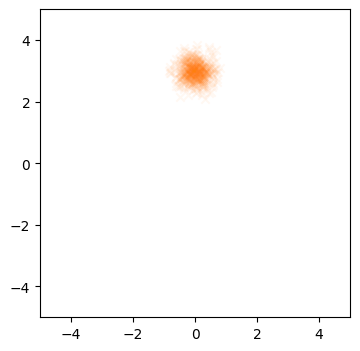

In [9]:
dataset_1 = CircleGaussiansDataset(n_gaussians=1, n_samples=500)
plt.figure(figsize=(4, 4))
plt.scatter(dataset_1.X[:,0], dataset_1.X[:,1], alpha=.05, marker='x', c='C1')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

### Affine flow 

Good final training loss is < 0.5

Epoch 0 -> loss: 4.42


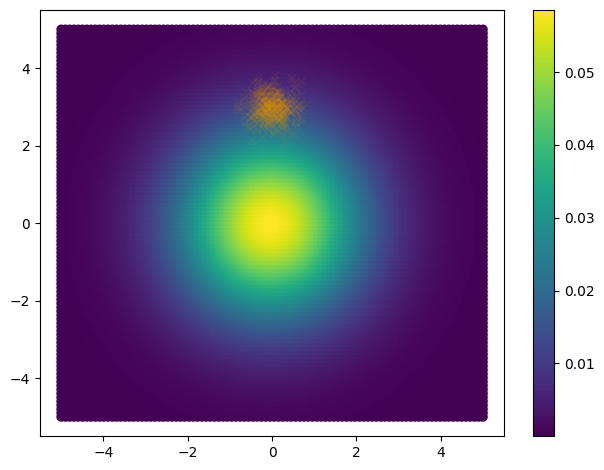

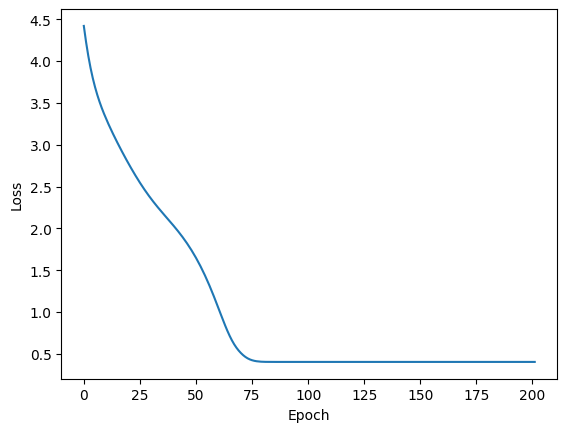

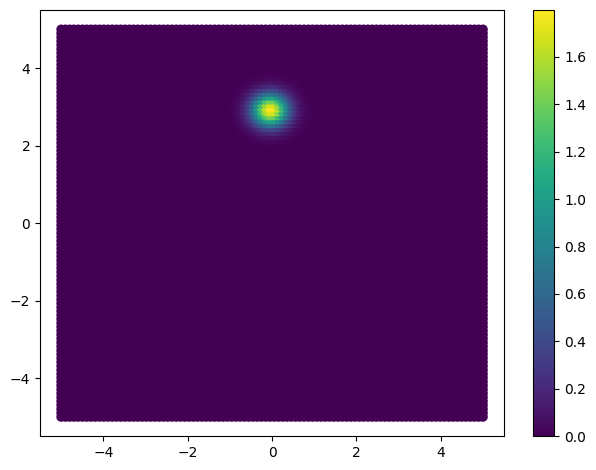

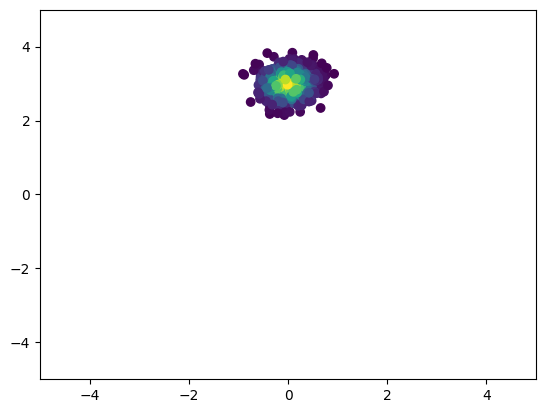

In [10]:
transforms = [Affine()]
model = StackedFlows(transforms, base_dist='Normal', device=device).to(device)
model, losses = train(model, dataset_1, max_epochs=201)

# Plots
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plot_density(model, [], device=device)
plot_samples(model)

### Radial flow (4 layers)

Epoch 0 -> loss: 4.80


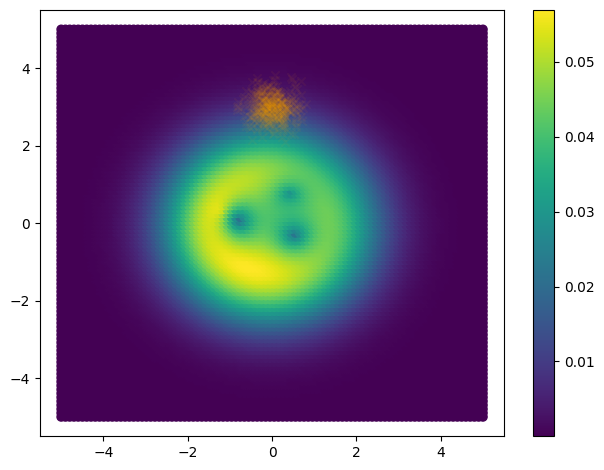

Epoch 250 -> loss: 0.85


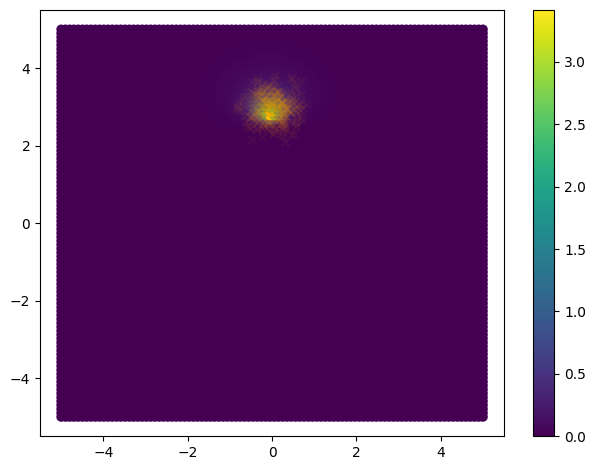

Epoch 500 -> loss: 0.42


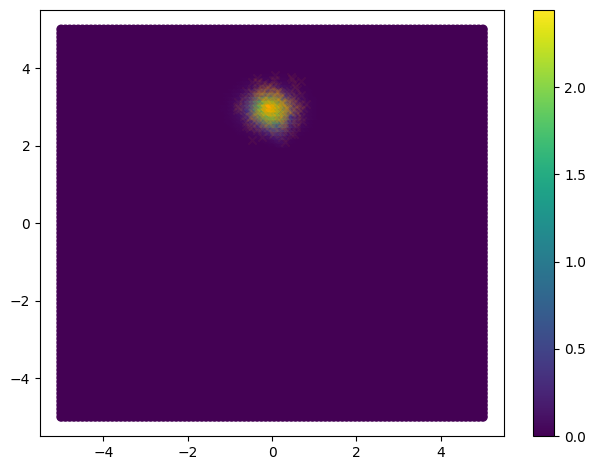

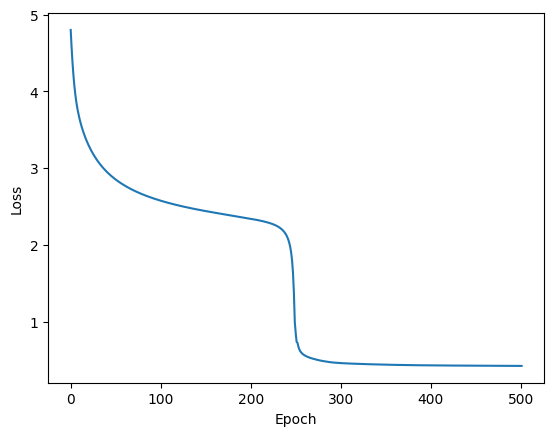

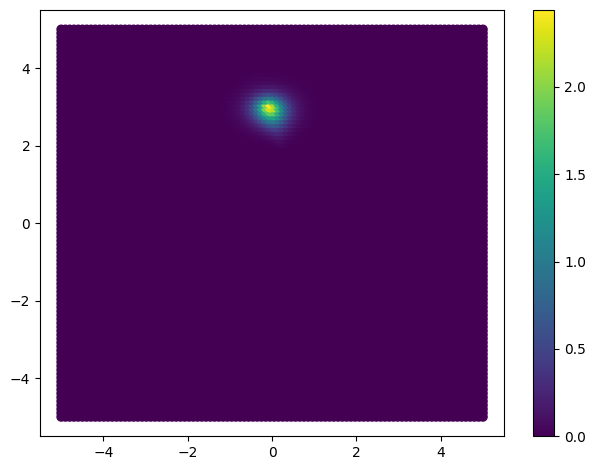

In [11]:
transforms = [Radial().get_inverse().to(device) for _ in range(4)]
model = StackedFlows(transforms, base_dist='Normal', device=device).to(device)
model, losses = train(model, dataset_1, max_epochs=501)

# Plots
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plot_density(model, [], device=device)

## Dataset 2: 3 Gaussians
The second dataset is composed of 3 gaussians with means on a circle.

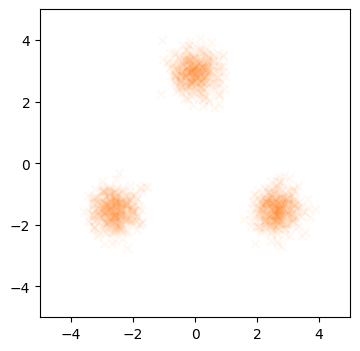

In [12]:
dataset_2 = CircleGaussiansDataset(n_gaussians=3, n_samples=400, variance=.4)
plt.figure(figsize=(4, 4))
plt.scatter(dataset_2.X[:,0], dataset_2.X[:,1], alpha=.05, marker='x', c='C1')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

### Affine flow

Affine flow should fail here.

Epoch 0 -> loss: 4.49


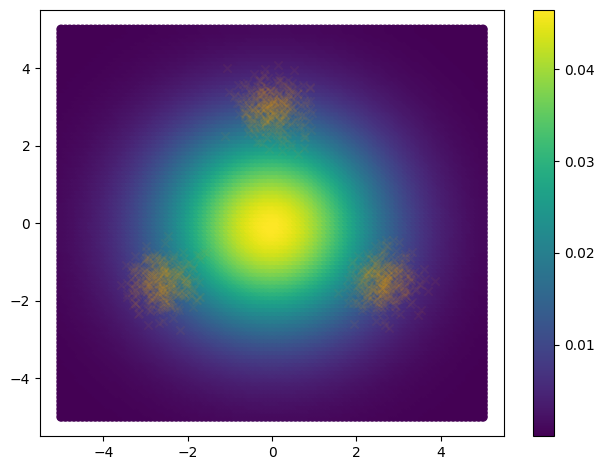

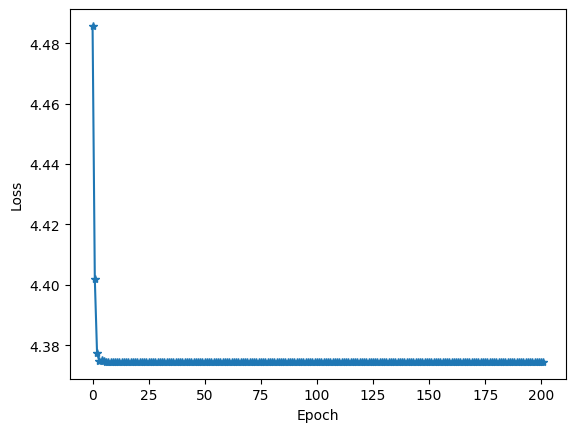

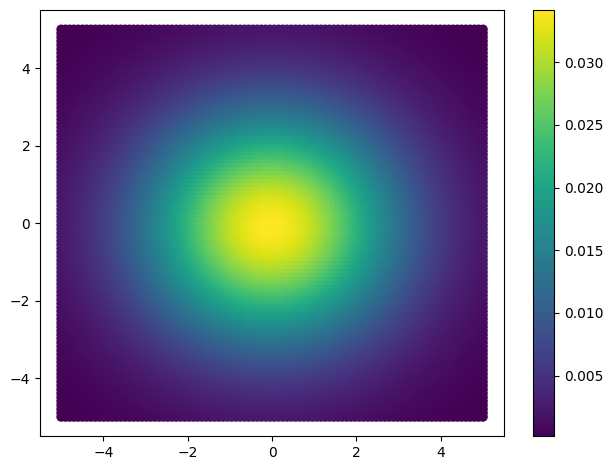

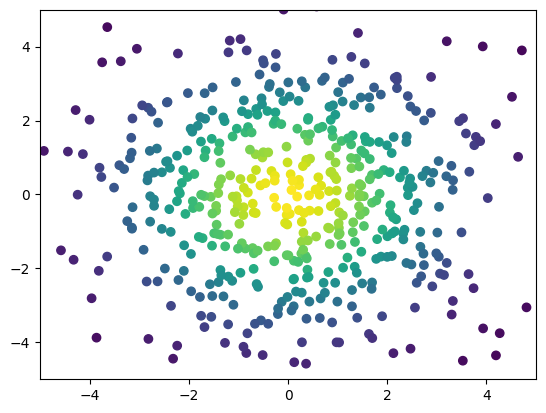

In [13]:
transforms = [Affine().to(device)]
model = StackedFlows(transforms, base_dist='Normal', device=device).to(device)
model, losses = train(model, dataset_2, max_epochs=201)

# Plots
plt.plot(losses, marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plot_density(model, [], device=device)
plot_samples(model)

### Radial flow (16 layers)

Using 16 layers of radial flow should lead to a good reasonable fit of the data after 500 epochs. Traning with more layers and for more epochs would improve the density estimation but would take more time. You might have to run the training multiple times to learn the three Gaussians (sometimes only two Gaussians are learned by the flow).

Good loss is < 2.5

Epoch 0 -> loss: 6.50


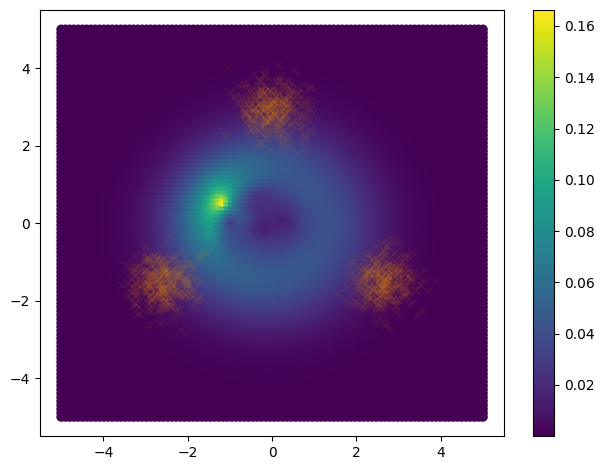

Epoch 100 -> loss: 2.89


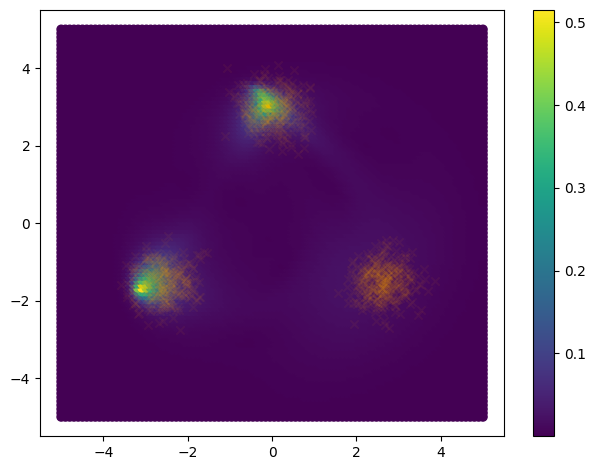

Epoch 200 -> loss: 2.45


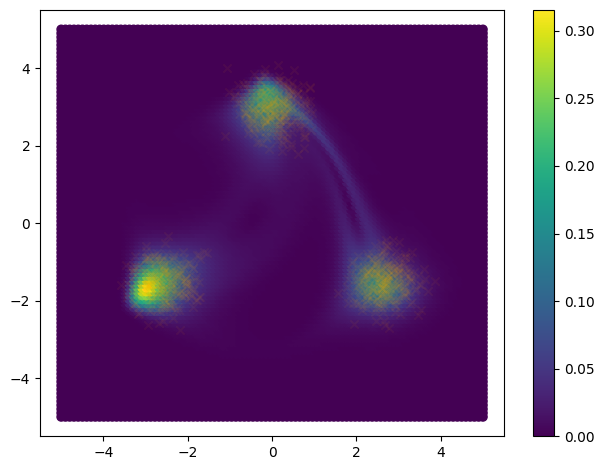

Epoch 300 -> loss: 2.36


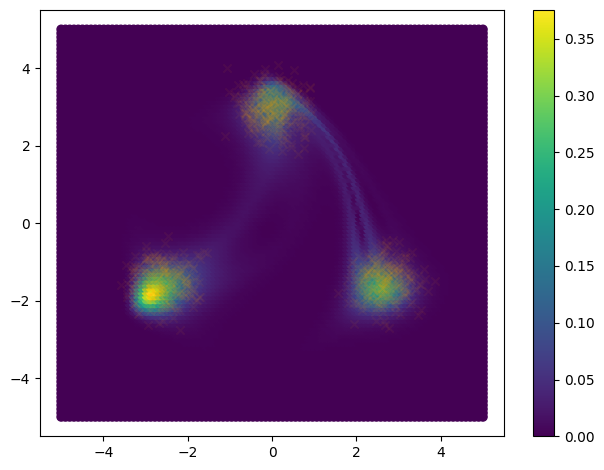

Epoch 400 -> loss: 2.32


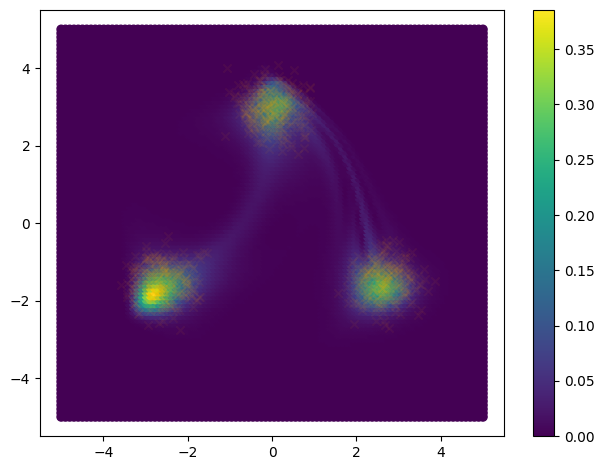

Epoch 500 -> loss: 2.31


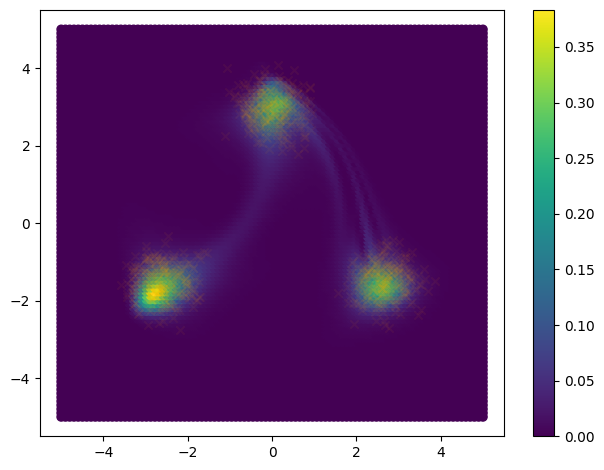

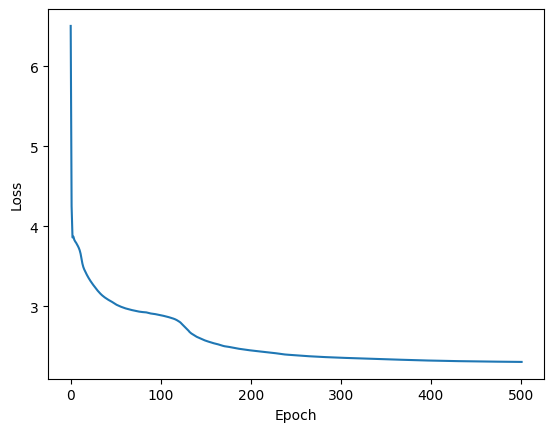

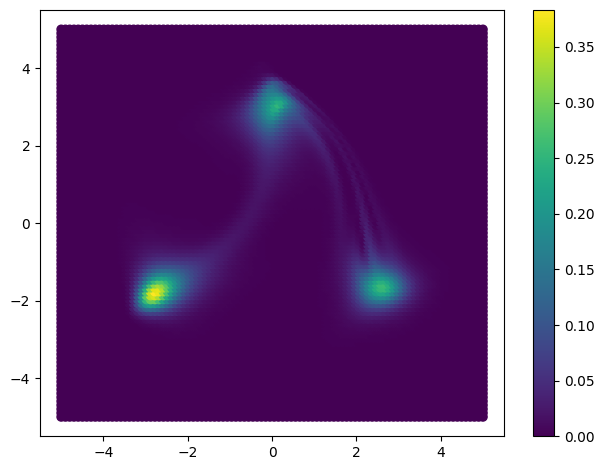

In [14]:
transforms = [Radial().get_inverse() for _ in range(16)]
model = StackedFlows(transforms, base_dist='Normal', device=device).to(device)
model, losses = train(model, dataset_2, max_epochs=501, frequency=100)

# Plots
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plot_density(model, [], device=device)

## Dataset 3: 2 Moons

The third dataset is composed of 2 moons. Affine flow should fail again. With more layers, Radial flow should work. 

In [15]:
class MoonsDataset(Dataset):
    """Create a 2D dataset with spirals.

    Args:
        n_samples: number of sample per spiral. int
        seed: random seed: int
    """
    def __init__(self, n_samples: int = 1200, seed: int = 0):

        self.n_samples = n_samples

        np.random.seed(seed)
        self.X, _ = make_moons(n_samples=n_samples, shuffle=True, noise=.05, random_state=None)

    def __len__(self) -> int:
        return self.n_samples

    def __getitem__(self, item: int) -> Tensor:
        x = torch.from_numpy(self.X[item]).type(torch.FloatTensor)
        return x

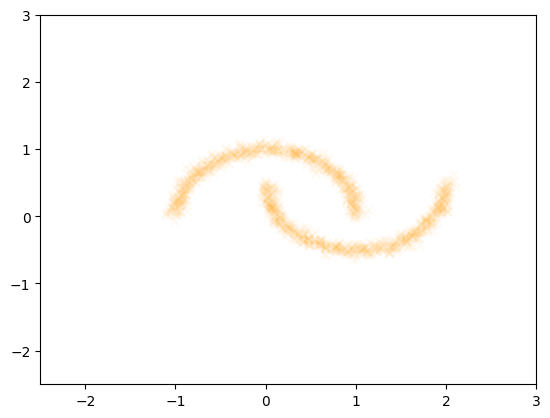

In [16]:
dataset_3 = MoonsDataset()
plt.scatter(dataset_3.X[:,0], dataset_3.X[:,1], alpha=.05, marker='x', c='orange')
plt.xlim(-2.5, 3)
plt.ylim(-2.5, 3)
plt.show()

### Affine flow 

Epoch 0 -> loss: 2.98


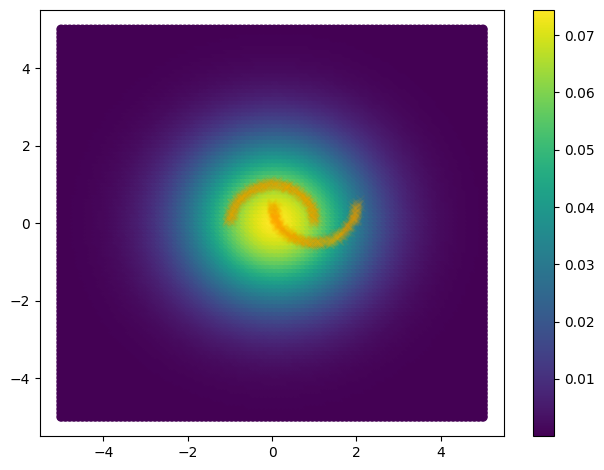

Epoch 250 -> loss: 2.00


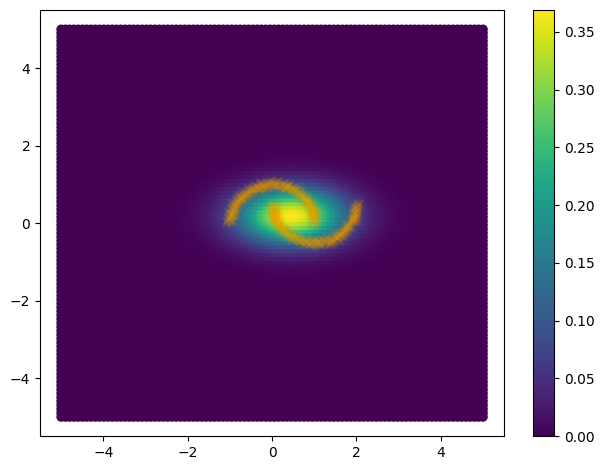

Epoch 500 -> loss: 2.00


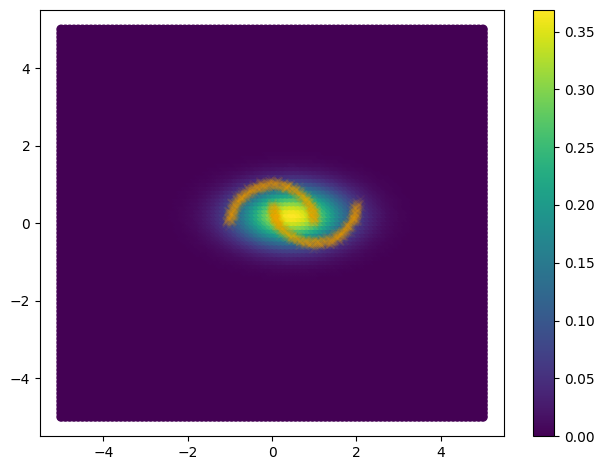

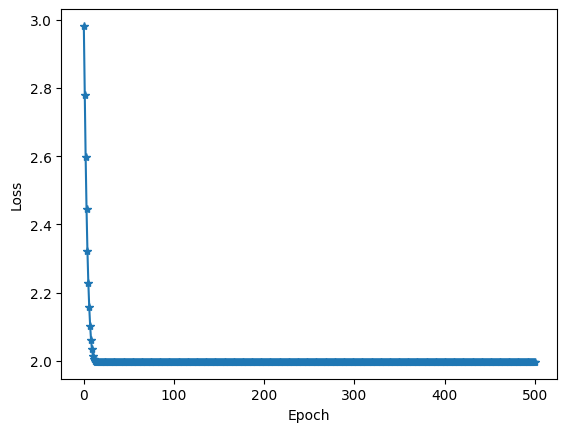

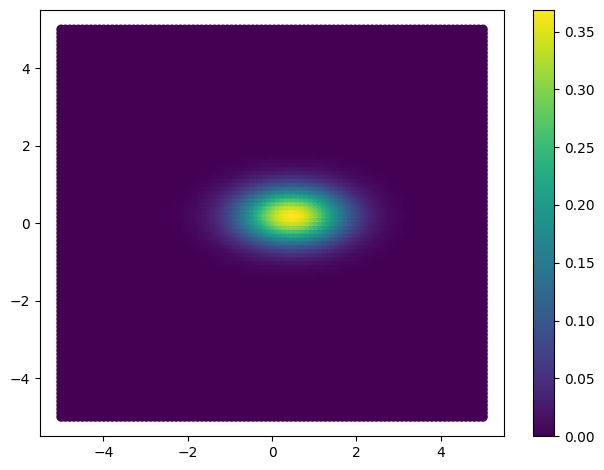

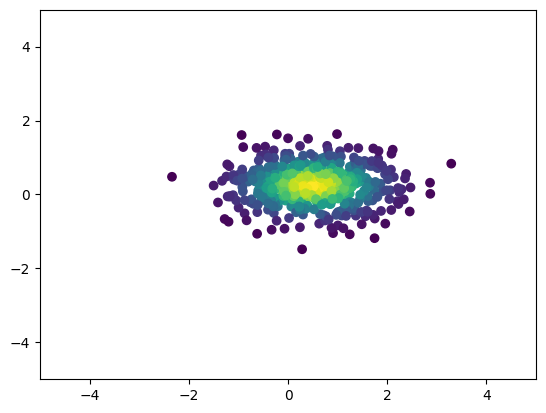

In [17]:
transforms = [Affine().to(device)]
model = StackedFlows(transforms, base_dist='Normal', device=device).to(device)
model, losses = train(model, dataset_3, max_epochs=500)

# Plots
plt.plot(losses, marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plot_density(model, [], device=device)
plot_samples(model)

Affine flow should fail here.

### Radial flow (16 layers)

Using 16 layers of radial flow should lead to a good reasonable fit of the data after 500 epochs. Traning with more layers and for more epochs would improve the density estimation but would take more time.

Good loss is < 1

Epoch 0 -> loss: 2.54


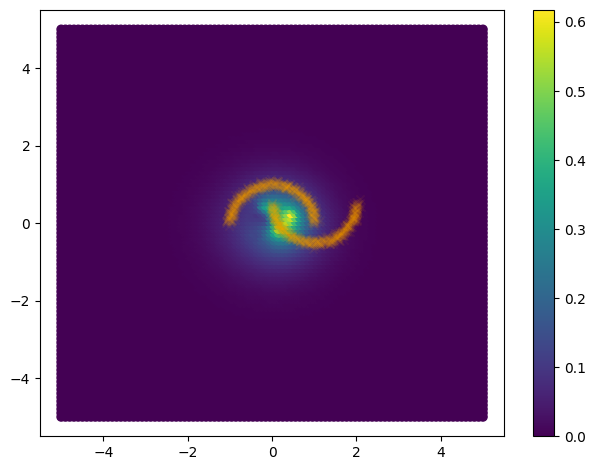

Epoch 100 -> loss: 0.97


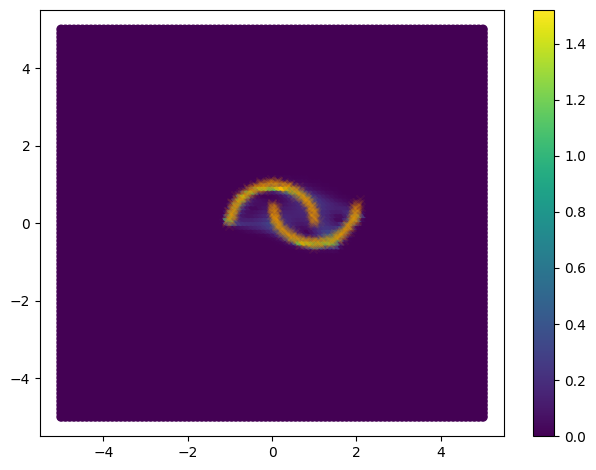

Epoch 200 -> loss: 0.86


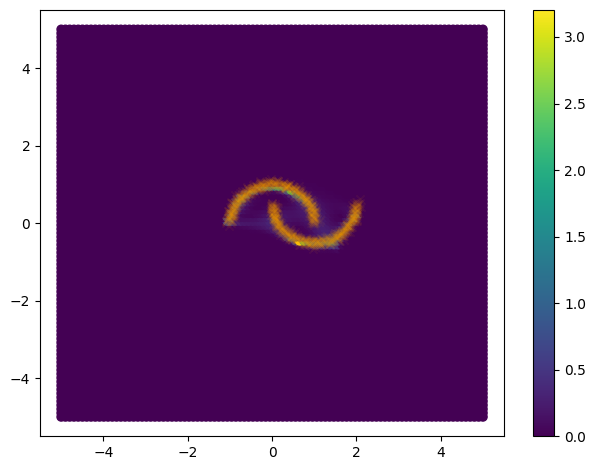

Epoch 300 -> loss: 0.81


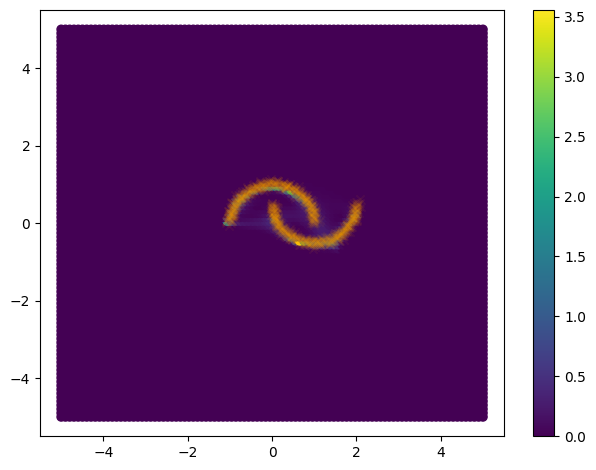

Epoch 400 -> loss: 0.79


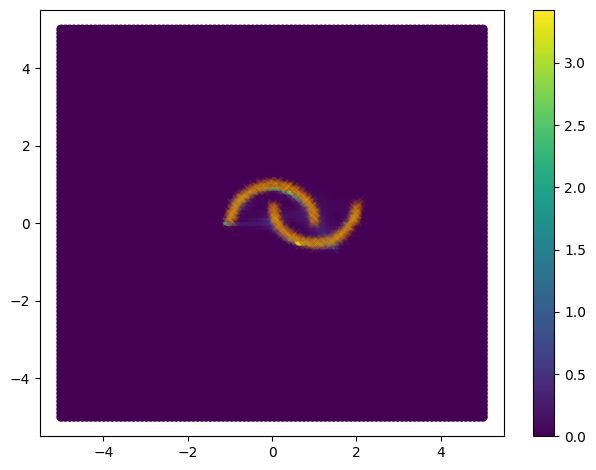

Epoch 500 -> loss: 0.77


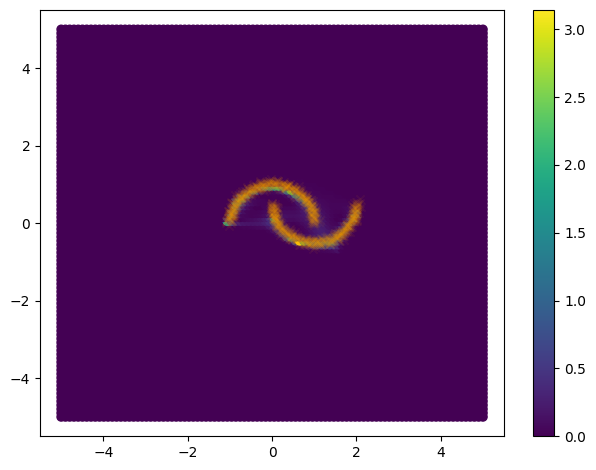

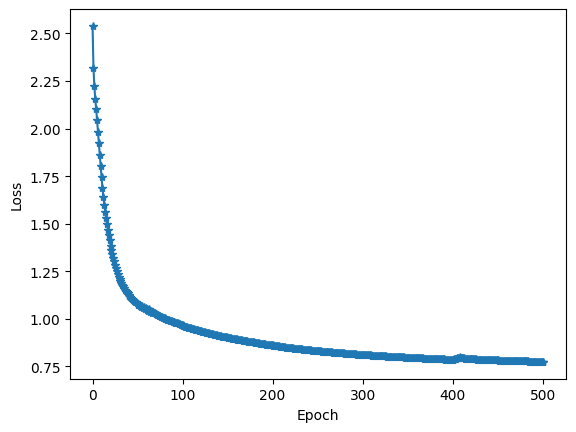

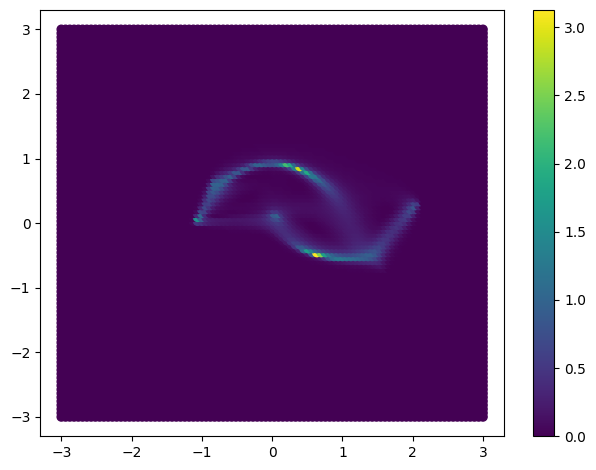

In [18]:
transforms = [Radial().get_inverse().to(device) for _ in range(16)]
model = StackedFlows(transforms, base_dist='Normal', device=device).to(device)
model, losses = train(model, dataset_3, max_epochs=501, frequency=100)

# Plots
plt.plot(losses, marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plot_density(model, [], mesh_size=3, device=device)